In [1]:
import tensorflow as tf
import input_data
import numpy as np
import random

# Dataset

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Validation split
valid_ratio = float(10)/55
train_pairs = zip(mnist.train.images, mnist.train.labels)
random.shuffle(train_pairs)
train_X, train_Y = zip(*train_pairs[int(valid_ratio*len(train_pairs)):])
valid_X, valid_Y = zip(*train_pairs[:int(valid_ratio*len(train_pairs))])

# Test pairs
test_X, test_Y = mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print 'Training:', len(train_X)
print 'Validation:', len(valid_X)
print 'Test:', len(test_X)

Training: 45000
Validation: 10000
Test: 10000


# Autoencoder

In [4]:
hidden_size = 100

In [5]:
def get_weights(shape, interval):
    val = np.random.uniform(-interval, interval, size=shape)
    val = np.cast['float32'](val)
    
    return tf.Variable(val)

def get_bias(shape, offset=0):
    val = np.zeros(shape) - offset
    val = np.cast['float32'](val)
    
    return tf.Variable(val)

In [6]:
def binomial_draw(shape=[1], p=0.5, dtype='float32'):
    return tf.select(tf.less(tf.random_uniform(shape=shape, minval=0, maxval=1, dtype='float32'), tf.fill(shape, p)), tf.ones(shape, dtype=dtype), tf.zeros(shape, dtype=dtype))

In [7]:
def add_noise(tensor, rate=0.2):
    # Salt and pepper noise
    a = binomial_draw(shape=tf.shape(tensor), p=1-rate, dtype='float32')
    b = binomial_draw(shape=tf.shape(tensor), p=0.5, dtype='float32')
    z = tf.zeros(tf.shape(tensor), dtype='float32')
    c = tf.select(tf.equal(a, z), b, z)
    
    return tf.add(tf.mul(tensor, a), c)

In [8]:
input_ = tf.placeholder(tf.float32, [None, 784])

In [9]:
# Binarize input
binarized_input = tf.floor(tf.add(input_, tf.fill(tf.shape(input_), 0.5)))

# Add noise to input
noised_input = add_noise(binarized_input)

# Input layer to hidden layer
W1 = get_weights([784, hidden_size], np.sqrt(6. / (784 + hidden_size)))
b1 = get_bias([hidden_size])

# Hidden layer to output layer
W2 = get_weights([hidden_size, 784], np.sqrt(6. / (784 + hidden_size)))
b2 = get_bias([784])

# Activations
hidden = tf.sigmoid(tf.matmul(noised_input, W1) + b1)
reconstruction = tf.sigmoid(tf.matmul(hidden, W2) + b2)

In [10]:
# Loss
clipped_output         = tf.clip_by_value(reconstruction, 1e-10, 1.0)
clipped_1_minus_output = tf.clip_by_value(1 - reconstruction, 1e-10, 1.0)

loss = -tf.reduce_sum(input_ * tf.log(clipped_output) + (1 - input_) * tf.log(clipped_1_minus_output))

In [11]:
# Optimizer
train_op_ae = tf.train.AdamOptimizer().minimize(loss)

In [12]:
batch_size = 64

In [13]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(20):
    train_loss = []
    valid_loss = []
    test_loss  = []

    for j in range(len(train_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, _ = sess.run([loss, train_op_ae], feed_dict={input_: train_X[start:end]})

        train_loss.append(loss_/(batch_size * 784))

    for j in range(len(valid_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_ = sess.run(loss, feed_dict={input_: valid_X[start:end]})

        valid_loss.append(loss_/(batch_size * 784))

    for j in range(len(test_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_ = sess.run(loss, feed_dict={input_: test_X[start:end]})

        test_loss.append(loss_/(batch_size * 784))

    print 'End of epoch %d:' % (i+1)
    print 'Training loss:', np.mean(train_loss), \
          'Validation loss:', np.mean(valid_loss), \
          'Test loss:', np.mean(test_loss)
    print

End of epoch 1:
Training loss: 0.268862433028 Validation loss: 0.24987622046 Test loss: 0.249193970787

End of epoch 2:
Training loss: 0.233223504832 Validation loss: 0.21536567946 Test loss: 0.214572083445

End of epoch 3:
Training loss: 0.203104907696 Validation loss: 0.19293178756 Test loss: 0.19186072896

End of epoch 4:
Training loss: 0.185536034461 Validation loss: 0.179738322956 Test loss: 0.178362003738

End of epoch 5:
Training loss: 0.174755580609 Validation loss: 0.17092540737 Test loss: 0.169331485909

End of epoch 6:
Training loss: 0.1671118459 Validation loss: 0.164517810181 Test loss: 0.162911806226

End of epoch 7:
Training loss: 0.161556074338 Validation loss: 0.159704786268 Test loss: 0.157932240697

End of epoch 8:
Training loss: 0.157220781872 Validation loss: 0.155887614427 Test loss: 0.154131377511

End of epoch 9:
Training loss: 0.153583596697 Validation loss: 0.152262590307 Test loss: 0.150331581656

End of epoch 10:
Training loss: 0.150077850209 Validation loss

# CNN

In [14]:
def get_random_normal_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [15]:
X = tf.reshape(reconstruction, shape=(-1, 28, 28, 1))
Y = tf.placeholder("float", [None, 10])

In [16]:
w     = get_random_normal_weights([3, 3, 1, 32])
conv1 = tf.nn.relu(tf.nn.conv2d(X, w, strides=[1, 1, 1, 1], padding='SAME'))             # shape=(?, 28, 28, 32)
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 14, 14, 32)

In [17]:
w     = get_random_normal_weights([3, 3, 32, 64])
conv2 = tf.nn.relu(tf.nn.conv2d(pool1, w, strides=[1, 1, 1, 1], padding='SAME'))         # shape=(?, 14, 14, 64)
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 7, 7, 64)

In [18]:
w        = get_random_normal_weights([7*7*64, 625])
reshaped = tf.reshape(pool2, [-1, 7*7*64]) # shape=(?, 4*4*128)
fullycon = tf.nn.relu(tf.matmul(reshaped, w))

In [19]:
w          = get_random_normal_weights([625, 10])
output     = tf.matmul(fullycon, w)
predict_op = tf.argmax(output, 1)

In [20]:
loss       = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, Y))
accuracy   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1)), tf.float32))
train_op   = tf.train.AdamOptimizer().minimize(loss)

In [21]:
batch_size = 64

In [22]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(20):
    train_loss = []
    valid_loss = []
    valid_acc  = []
    test_loss  = []
    test_acc   = []

    for j in range(len(train_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, _ = sess.run([loss, train_op], feed_dict={input_: train_X[start:end], Y: train_Y[start:end]})

        train_loss.append(loss_)
        
        if j > 0 and j % 100 == 0:
            print ('Step %d: ' % j), np.mean(train_loss[(j-100):j])

    for j in range(len(valid_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, acc_ = sess.run([loss, accuracy], feed_dict={input_: valid_X[start:end], Y: valid_Y[start:end]})

        valid_loss.append(loss_)
        valid_acc.append(acc_)

    for j in range(len(test_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, acc_ = sess.run([loss, accuracy], feed_dict={input_: test_X[start:end], Y: test_Y[start:end]})

        test_loss.append(loss_)
        test_acc.append(acc_)

    print 'End of epoch %d:' % (i+1)
    print 'Training loss:', np.mean(train_loss), \
          'Validation loss:', np.mean(valid_loss), \
          'Test loss:', np.mean(test_loss)
    print ('Validation accuracy: %g%%' % (np.mean(valid_acc) * 100)), \
          ('Test accuracy: %g%%' % (np.mean(test_acc) * 100))
    print

Step 100:  2.30175
Step 200:  2.03381
Step 300:  1.732
Step 400:  1.60573
Step 500:  1.38764
Step 600:  0.953321
Step 700:  0.789282
End of epoch 1:
Training loss: 1.54044 Validation loss: 0.725793 Test loss: 0.697515
Validation accuracy: 76.242% Test accuracy: 77.2236%

Step 100:  0.683511
Step 200:  0.622878
Step 300:  0.5709
Step 400:  0.54238
Step 500:  0.489986
Step 600:  0.44784
Step 700:  0.413452
End of epoch 2:
Training loss: 0.538667 Validation loss: 0.455589 Test loss: 0.443421
Validation accuracy: 85.4467% Test accuracy: 85.9475%

Step 100:  0.415566
Step 200:  0.375017
Step 300:  0.359463
Step 400:  0.363865
Step 500:  0.334272
Step 600:  0.325343
Step 700:  0.310874
End of epoch 3:
Training loss: 0.35526 Validation loss: 0.305042 Test loss: 0.298381
Validation accuracy: 90.5148% Test accuracy: 90.605%

Step 100:  0.314843
Step 200:  0.276709
Step 300:  0.288471
Step 400:  0.296554
Step 500:  0.279026
Step 600:  0.264797
Step 700:  0.262252
End of epoch 4:
Training loss: 0

# Demonstration

In [23]:
from matplotlib.pyplot import imshow

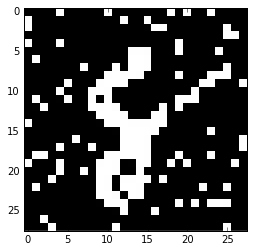

In [24]:
%matplotlib inline
# Input
this_input, this_label = random.sample(zip(test_X, test_Y), 1)[0]
this_noised_input, label = sess.run([noised_input, predict_op], feed_dict={input_: [this_input], Y: [np.zeros_like(this_label)]})
imshow(np.reshape(this_noised_input, (28, 28)), interpolation='none', cmap='Greys_r')

In [25]:
# Prediction
print label[0]

8
